In [2]:
import pandas as pd
import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data
from augerscalerpy.plot_config import configure_plots
from scipy.signal import correlate
from IPython.display import Image

3.7.0


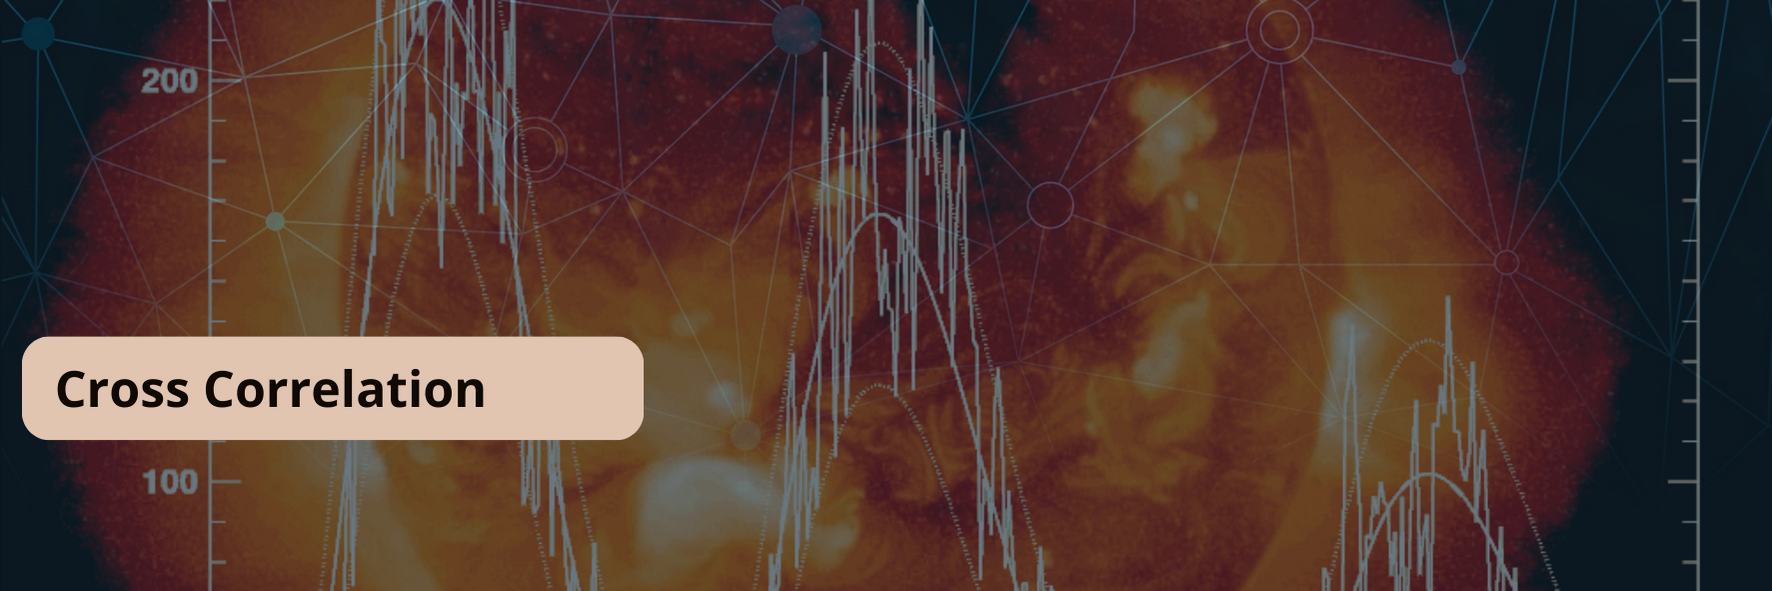

In [2]:
ruta_imagen_local = '/home/jennifer/Documentos/msc_tesis/P5.png'

Image(filename=ruta_imagen_local)

### Cálculo a mano de la correlación del Artículo

#### Parámetros solares + CRI Pierre Auger:
- Todo está normalizado

In [3]:
solar_par = pd.read_csv('solar_parameters/auger_solar_parameter_NORM.csv')

#### Dataset Neutron Monitor (including Auger)

In [4]:
NMs = pd.read_csv('nm_data/CRI_auger_NM_3H_NORM.csv')
NMs['date'] = pd.to_datetime(NMs['date'])
NMs.set_index('date', inplace=True)

In [5]:
len(NMs)

93496

In [6]:
NM_resampled = NMs.resample('1D').mean()

In [7]:
NM_resampled.reset_index(inplace=True)
NMs = NM_resampled[['date','oulu','mexico','tsumeb']].copy()

In [8]:
# Asegurémonos de que las columnas 'date' sean de tipo datetime en ambos DataFrames
solar_par['date'] = pd.to_datetime(solar_par['date'])
NMs['date'] = pd.to_datetime(NMs['date']).dt.tz_localize(None)

#### Dataset con los datos solares + Pierre Auger + Oulu + Mexico

In [9]:
merged = pd.merge_asof(solar_par, NMs, on='date', direction='backward', tolerance=pd.Timedelta('1D'))

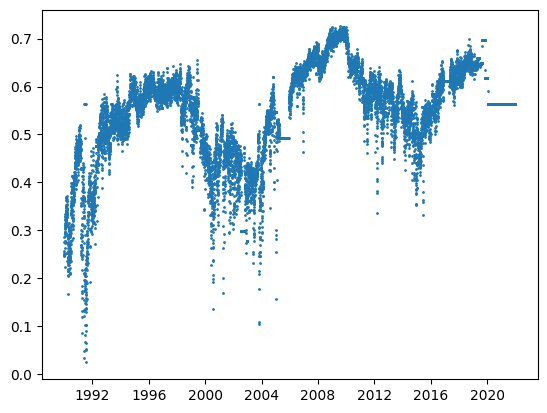

In [10]:
plt.scatter(merged['date'],merged['tsumeb'],s=1)

# Correlaciones con Oulu

In [13]:
##### FILTRADOOOOO
# Filtrando los datos para el rango de años DEL DETECTOR
start_date = '2005-01-01'
end_date = '2021-09-30'
oulu_corr = merged[(merged['date'] >= start_date) & (merged['date'] <= end_date)]
oulu_corr.set_index('date', inplace=True)
oulu_corr = oulu_corr.astype('float64') # 

In [14]:
configure_plots()
# 1. Calcular los valores medios de ambas variables
mean_counts_o = oulu_corr["oulu"].mean()
mean_sunspots_o = oulu_corr["sunspots"].mean()
# 2. Calcular los desplazamientos (\Delta)
max_lag = 30  # Establece el número máximo de desplazamientos a considerar (30 días para incluir hasta el ciclo de hasta ~27 días)
# 3. Calcular las desviaciones estándar normalizadas (\delta_{p} y \delta_{q})
std_counts_o = oulu_corr["oulu"].std()
std_sunspots_o = oulu_corr["sunspots"].std()
# 4. Inicializar una lista para almacenar los coeficientes de correlación cruzada
cross_correlations_o = []
# 6. Aplicar la fórmula de correlación cruzada para cada desplazamiento (\Delta)
for lag in range(-max_lag, max_lag + 1):
    sum_product_o = 0
    #
    for i in range(len(oulu_corr) - abs(lag)):
        diff_counts_o = oulu_corr["oulu"].iloc[i] - mean_counts_o
        diff_sunspots_o = oulu_corr["sunspots"].iloc[i + lag] - mean_sunspots_o
        sum_product_o += diff_counts_o * diff_sunspots_o
    # Cálculo del coeficiente de correlación cruzada para el desplazamiento actual
    cross_corr_o = (1 / (len(oulu_corr) - 1)) * (sum_product_o / (std_counts_o * std_sunspots_o))
    cross_correlations_o.append(cross_corr_o)

# Ahora cross_correlations contiene los coeficientes de correlación cruzada para diferentes desplazamientos
# Imprimir valor para un desplazamiento de 0:
lag_0_corr_o = cross_correlations_o[max_lag]
print("Coeficiente de correlación cruzada para desplazamiento 0:", lag_0_corr_o)

Coeficiente de correlación cruzada para desplazamiento 0: -0.5134993706917296


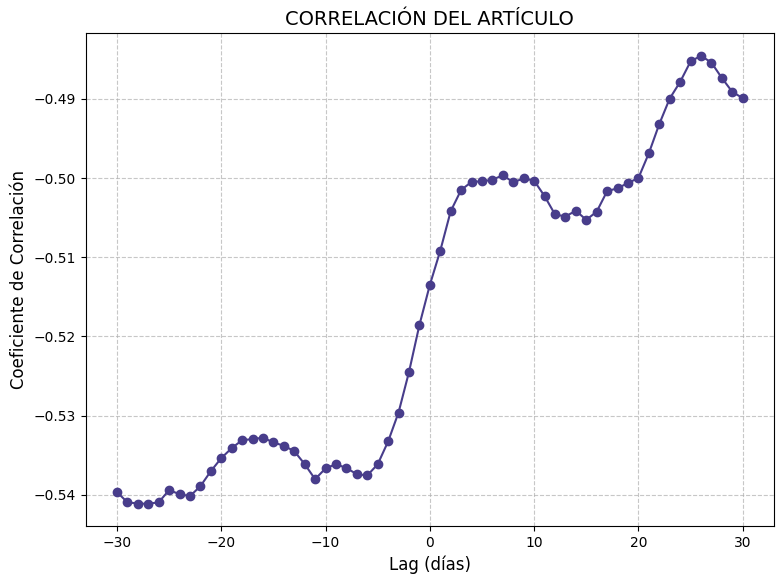

In [15]:
lag_range_o = list(range(-max_lag, max_lag + 1))
plt.plot(lag_range_o, cross_correlations_o, marker='o', linestyle='-', color='darkslateblue')  # Personaliza el color a tu elección
plt.xlabel('Lag (días)')
plt.ylabel('Coeficiente de Correlación')
plt.title('CORRELACIÓN DEL ARTÍCULO')
plt.grid(True, linestyle='--', alpha=0.7)  # Añade una grilla con estilo punteado y transparencia
plt.tight_layout()  # Ajusta el espacio para que todos los elementos se muestren correctamente
plt.show()

## Correlación con un lag mensual

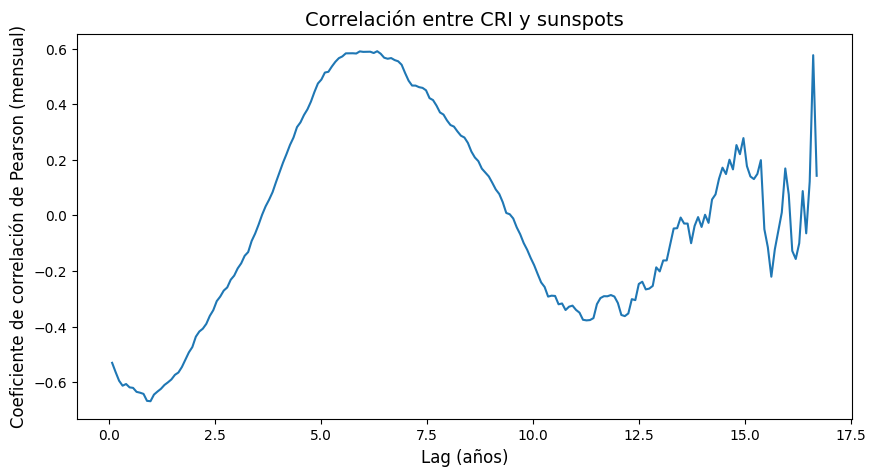

In [16]:
lags = np.arange(30, 30*12*25, 30)  # Lags de 1 mes a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = oulu_corr['sunspots'].shift(lag)
    correlation = oulu_corr['oulu'].corr(shifted)
    correlations.append(correlation)
# Convertir lags a años para la gráfica
lags_years = lags / 365
# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(10, 5))
plt.plot(lags_years, correlations)
plt.xlabel('Lag (años)')
plt.ylabel('Coeficiente de correlación de Pearson (mensual)')
plt.title('Correlación entre CRI y sunspots')
plt.show()

## Prueba Negativo y Positivo
### Con mi código a mano

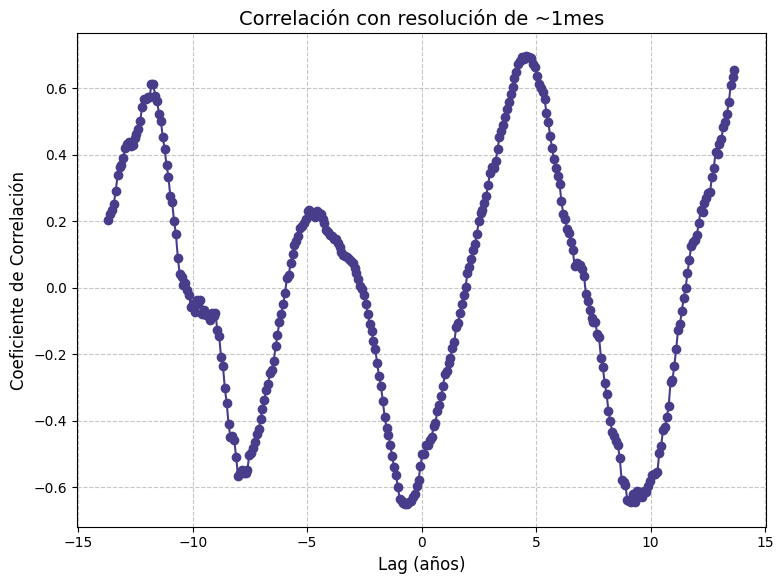

In [13]:
configure_plots()
mean_counts_o = oulu_corr["oulu"].mean()
mean_sunspots_o = oulu_corr["sunspots"].mean()
max_lag = 5000  # Establece el número máximo de desplazamientos a considerar (30 días para incluir hasta el ciclo de hasta ~27 días)
std_counts_o = oulu_corr["oulu"].std()
std_sunspots_o = oulu_corr["sunspots"].std()
cross_correlations_o = []
for lag in range(-max_lag, max_lag + 1,30):
    sum_product_o = 0
    n = len(oulu_corr) - abs(lag)  # Número de observaciones
    for i in range(n):
        diff_counts_o = oulu_corr["oulu"].iloc[i] - mean_counts_o
        diff_sunspots_o = oulu_corr["sunspots"].iloc[i + lag] - mean_sunspots_o
        sum_product_o += diff_counts_o * diff_sunspots_o
    cross_corr_o = (1 / (n - 1)) * (sum_product_o / (std_counts_o * std_sunspots_o))  # Dividir por n-1 en lugar de len(oulu_corr) - 1
    cross_correlations_o.append(cross_corr_o)
lag_range_o = list(range(-max_lag, max_lag + 1,30))
lag_range_o_years = [lag / 365.25 for lag in lag_range_o]
plt.plot(lag_range_o_years, cross_correlations_o, marker='o', linestyle='-', color='darkslateblue')  # Personaliza el color a tu elección
plt.xlabel('Lag (años)')
plt.ylabel('Coeficiente de Correlación')
plt.title('Correlación con resolución de ~1mes')
plt.grid(True, linestyle='--', alpha=0.7)  # Añade una grilla con estilo punteado y transparencia
plt.tight_layout()  # Ajusta el espacio para que todos los elementos se muestren correctamente
plt.show()


### Con la librería de Scipy

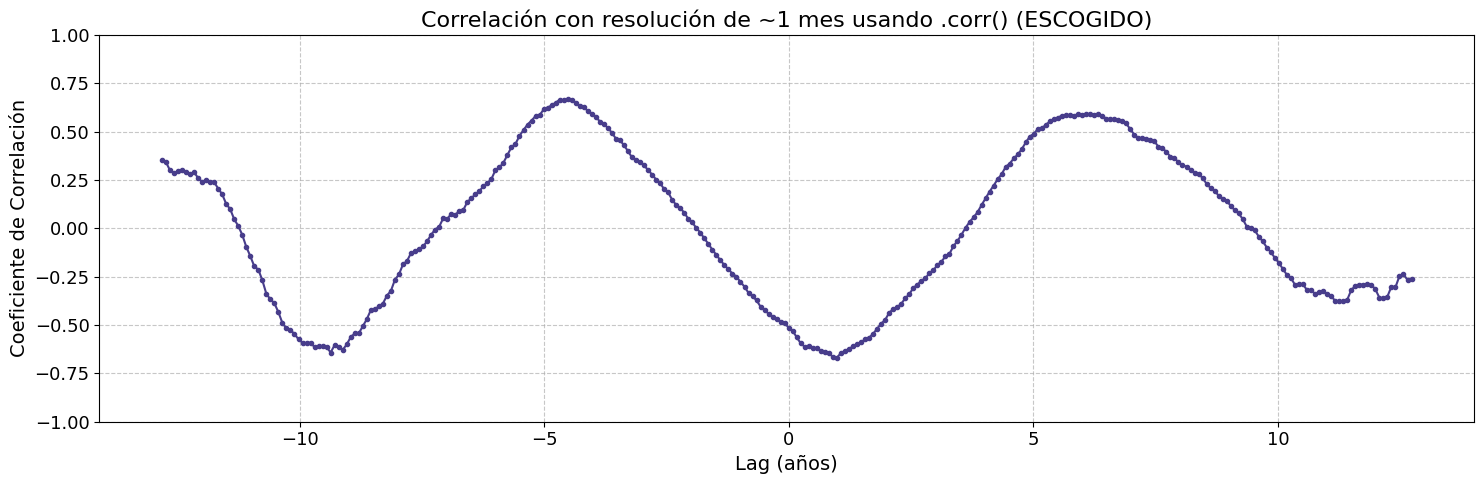

In [14]:
lags = np.arange(-30*12*13, 30*12*13, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = oulu_corr['sunspots'].shift(lag)
    correlation = oulu_corr['oulu'].corr(shifted)
    correlations.append(correlation)
# Convertir lags a años para la gráfica
lags_years = lags / 365.25
# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(15, 5))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('Coeficiente de Correlación', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('Correlación con resolución de ~1 mes usando .corr() (ESCOGIDO)', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1
plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

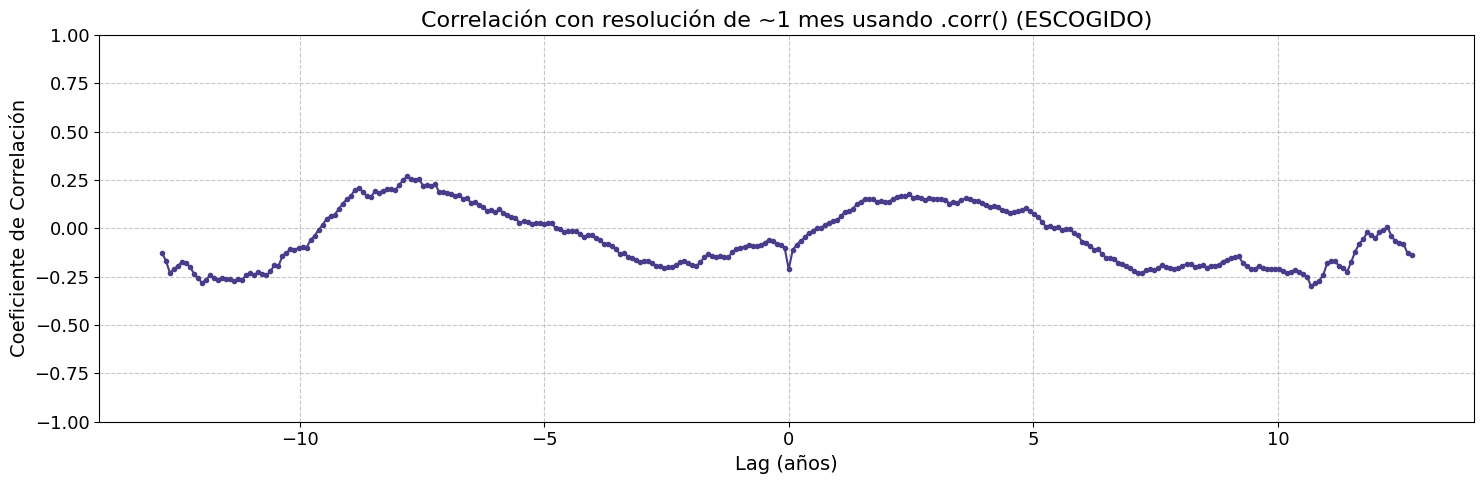

In [15]:
lags = np.arange(-30*12*13, 30*12*13, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = oulu_corr['solarw'].shift(lag)
    correlation = oulu_corr['oulu'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(15, 5))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('Coeficiente de Correlación', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('Correlación con resolución de ~1 mes usando .corr() (ESCOGIDO)', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1
plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

# Correlación Auger - Sunspots

In [17]:
merged

date  sunspots    solarw       CRI  oulu  mexico  tsumeb
0     1818-01-01       NaN       NaN       NaN   NaN     NaN     NaN
1     1818-01-02       NaN       NaN       NaN   NaN     NaN     NaN
2     1818-01-03       NaN       NaN       NaN   NaN     NaN     NaN
3     1818-01-04       NaN       NaN       NaN   NaN     NaN     NaN
4     1818-01-05       NaN       NaN       NaN   NaN     NaN     NaN
...          ...       ...       ...       ...   ...     ...     ...
75143 2023-09-26  0.360587  0.332099  0.469676   NaN     NaN     NaN
75144 2023-09-27  0.383648  0.323457  0.469676   NaN     NaN     NaN
75145 2023-09-28  0.197065  0.248148  0.469676   NaN     NaN     NaN
75146 2023-09-29  0.188679  0.293827  0.469676   NaN     NaN     NaN
75147 2023-09-30  0.226415  0.270370  0.469676   NaN     NaN     NaN

[75148 rows x 7 columns]

In [18]:
##### FILTRADOOOOO
# Filtrando los datos para el rango de años de enero de 2006 a septiembre de 2021
start_date = '2006-01-01'
end_date = '2021-09-30'
df = merged[(merged['date'] >= start_date) & (merged['date'] <= end_date)]
df.set_index('date', inplace=True)
df = df.astype('float64') # 

# Auger

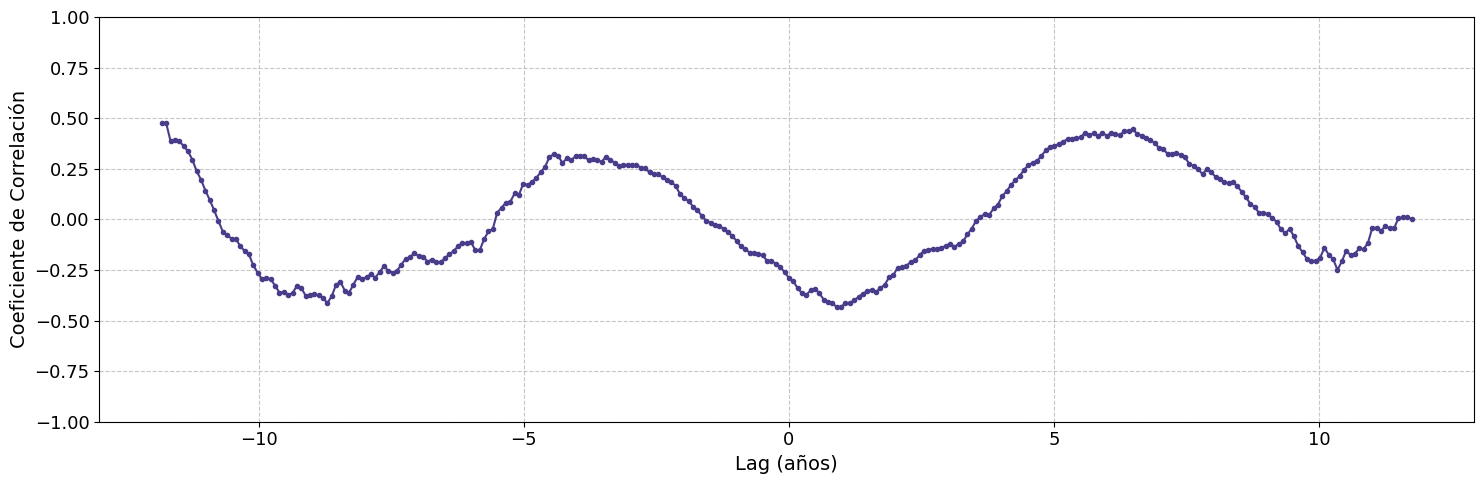

In [18]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = df['sunspots'].shift(lag)
    correlation = df['CRI'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(15, 5))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('Coeficiente de Correlación', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1
plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

# Oulu

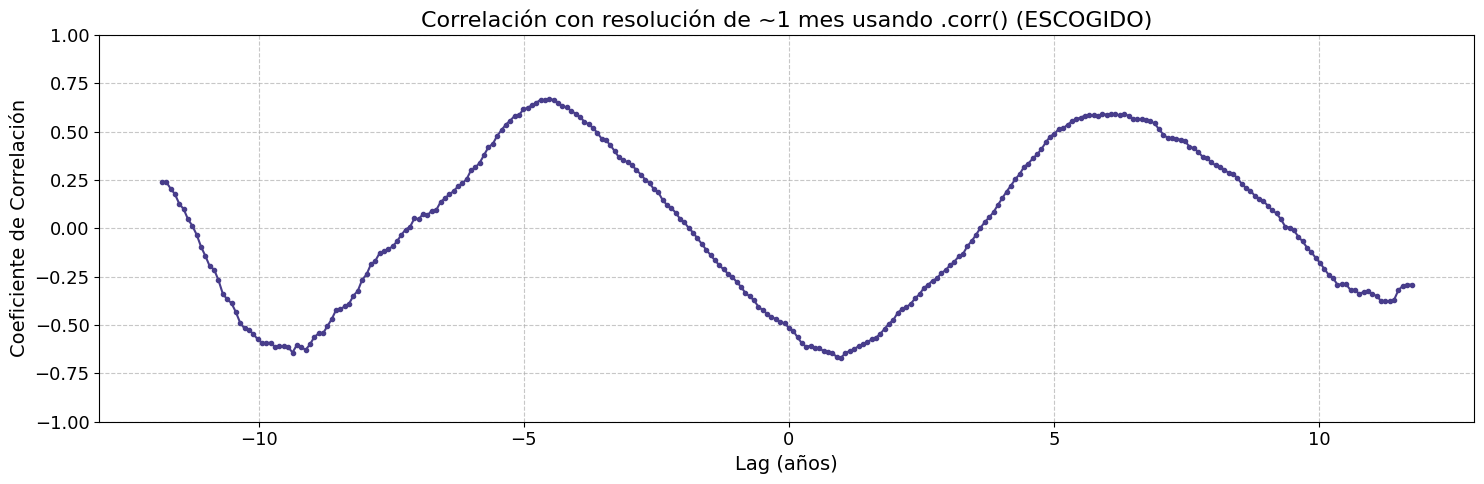

In [19]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = oulu_corr['sunspots'].shift(lag)
    correlation = oulu_corr['oulu'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(15, 5))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('Coeficiente de Correlación', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('Correlación con resolución de ~1 mes usando .corr() (ESCOGIDO)', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1
plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

# México

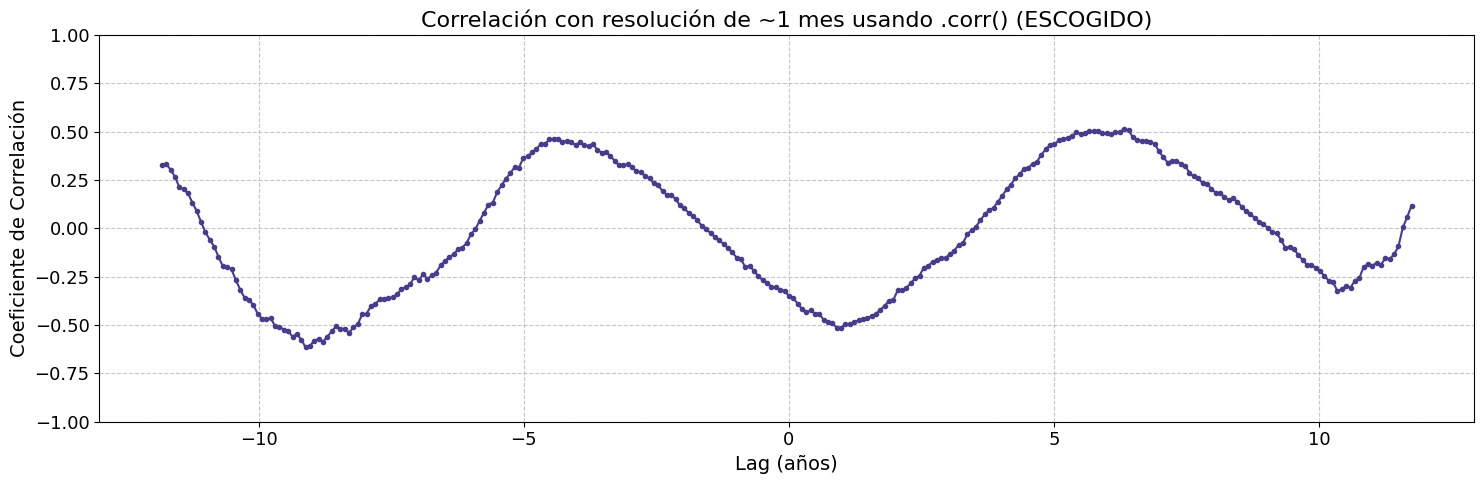

In [20]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = oulu_corr['sunspots'].shift(lag)
    correlation = oulu_corr['mexico'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(15, 5))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('Coeficiente de Correlación', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('Correlación con resolución de ~1 mes usando .corr() (ESCOGIDO)', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1
plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

# Tsumeb

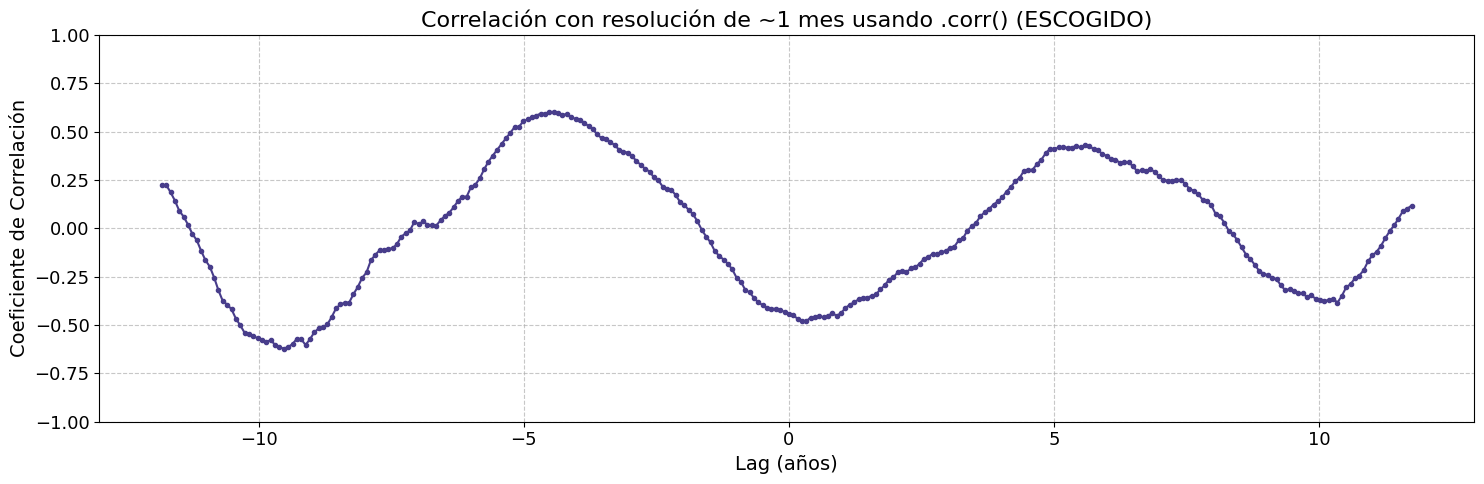

In [21]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = oulu_corr['sunspots'].shift(lag)
    correlation = oulu_corr['tsumeb'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(15, 5))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('Coeficiente de Correlación', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('Correlación con resolución de ~1 mes usando .corr() (ESCOGIDO)', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1
plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

In [24]:
df.reset_index(inplace=True)

# Auger - Tsumeb

In [25]:
porcentajes = abs(df['tsumeb'] - df['CRI']) / ((df['tsumeb'] + df['CRI']) / 2) * 100
media = np.mean(porcentajes)
media

30.385913561012618

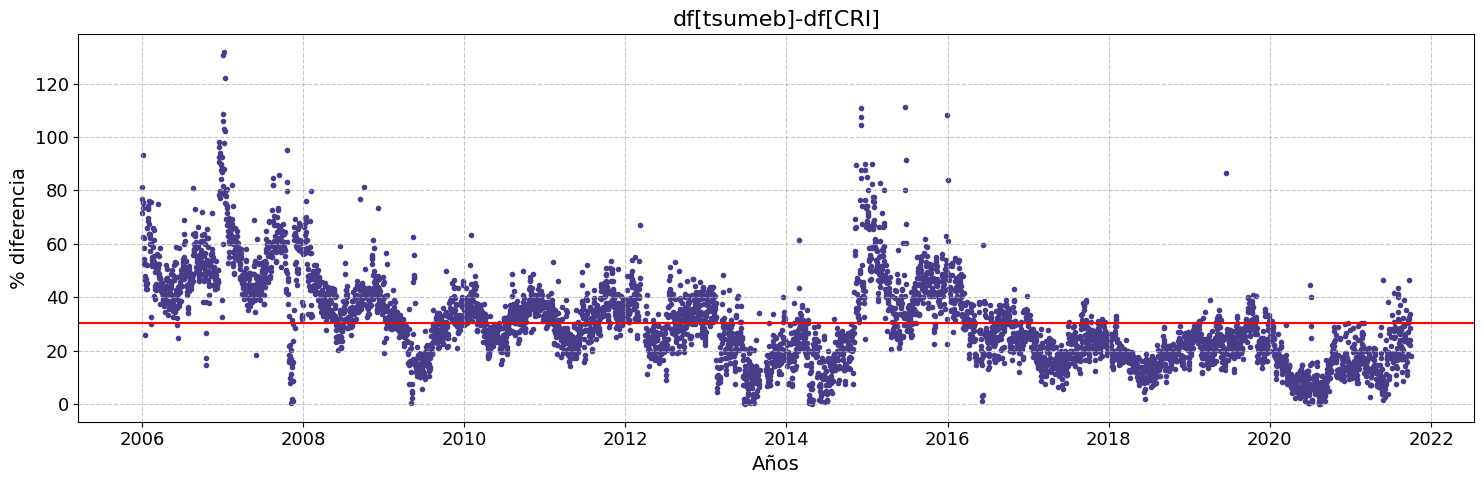

In [26]:
plt.figure(figsize=(15, 5))
plt.scatter(df['date'], porcentajes, marker='.', linestyle='-', color='darkslateblue')



plt.xlabel('Años', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('% diferencia', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('df[tsumeb]-df[CRI]', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1

plt.axhline(media, color='red', linestyle='-')

#plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

# Auger - Mexico

In [27]:
porcentajes = abs(df['mexico'] - df['CRI']) / ((df['mexico'] + df['CRI']) / 2) * 100
media = np.mean(porcentajes)
media

30.89917012535897

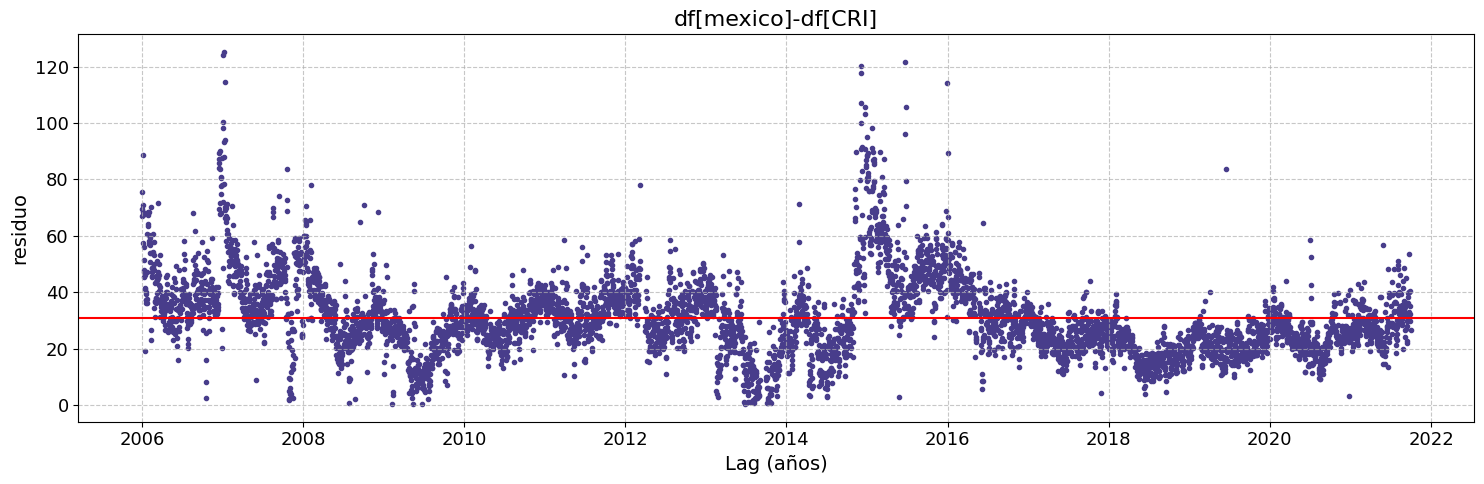

In [28]:
plt.figure(figsize=(15, 5))
plt.scatter(df['date'], porcentajes, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('residuo', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('df[mexico]-df[CRI]', fontsize=16)  # Aumenta el tamaño del título
# Configurar el rango del eje y a -1 a 1
plt.axhline(media, color='red', linestyle='-')

#plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

# Auger - Oulu

In [29]:
porcentajes = abs(df['oulu'] - df['CRI']) / ((df['oulu'] + df['CRI']) / 2) * 100
media = np.mean(porcentajes)
media

32.821608606583865

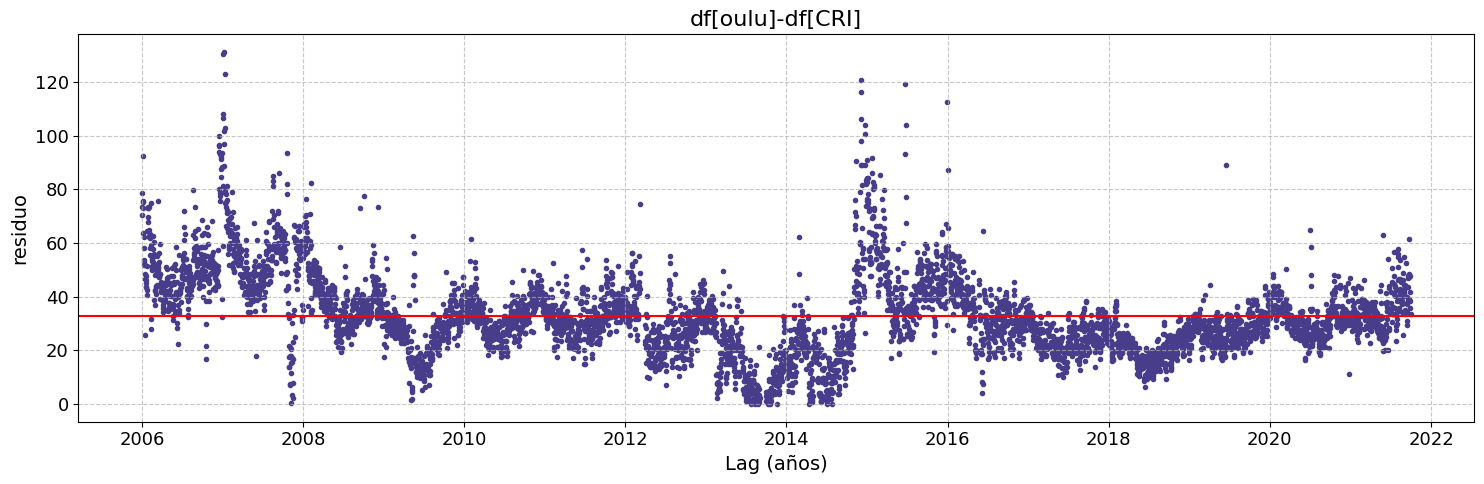

In [30]:
plt.figure(figsize=(15, 5))
plt.scatter(df['date'], porcentajes, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje x
plt.ylabel('residuo', fontsize=14)  # Aumenta el tamaño de la etiqueta del eje y
plt.title('df[oulu]-df[CRI]', fontsize=16)  # Aumenta el tamaño del título

plt.axhline(media, color='red', linestyle='-')

# Configurar el rango del eje y a -1 a 1
#plt.ylim(-1, 1)
# Añadir una grilla con estilo punteado y transparencia
plt.grid(True, linestyle='--', alpha=0.7)
# Aumentar el tamaño de los números en los ejes
plt.tick_params(axis='both', labelsize=13)
# Ajustar el espacio para que todos los elementos se muestren correctamente
plt.tight_layout()
# Mostrar la gráfica
plt.show()

In [ ]:
# SUPERPUESTOS MANCHAS Y SOLARWIND

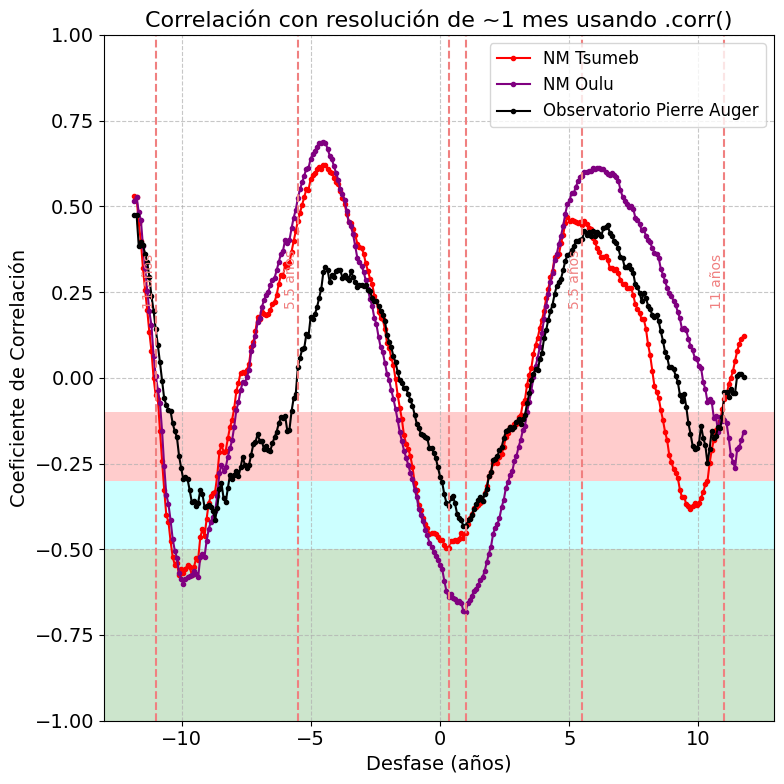

In [20]:
# Define un rango de desfases
lags = np.arange(-30*12*12, 30*12*12, 30)  # Desfases de -12 años a 12 años (en días)

# Define una función para calcular correlaciones con desfases
def calculate_correlations(df, column1, column2, lags):
    correlations = []
    for lag in lags:
        shifted = df[column1].shift(lag)
        correlation = df[column2].corr(shifted)
        correlations.append(correlation)
    return correlations

# Calcula las correlaciones
correlations_CRI = calculate_correlations(df, 'sunspots', 'CRI', lags)
correlations_tsumeb = calculate_correlations(df, 'sunspots', 'tsumeb', lags)
correlations_oulu = calculate_correlations(df, 'sunspots', 'oulu', lags)

# Convierte los desfases a años para la gráfica
lags_years = lags / 365.25

# Crea una gráfica de los coeficientes de correlación
plt.figure(figsize=(8, 8))  # Ajusté el tamaño del gráfico para una mejor visualización
plt.plot(lags_years, correlations_tsumeb, marker='.', linestyle='-', color='red', label='NM Tsumeb')
plt.plot(lags_years, correlations_oulu, marker='.', linestyle='-', color='purple', label='NM Oulu')
plt.plot(lags_years, correlations_CRI, marker='.', linestyle='-', color='black', label='Observatorio Pierre Auger')
plt.xlabel('Desfase (años)', fontsize=14)
plt.ylabel('Coeficiente de Correlación', fontsize=14)
plt.title('Correlación con resolución de ~1 mes usando .corr()', fontsize=16)
plt.ylim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje x
plt.yticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje y

# Añadir líneas verticales en 5.5 y 11 años
plt.axvline(x=5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=0.34, color='lightcoral', linestyle='--', label='')
plt.axvline(x=1, color='lightcoral', linestyle='--', label='')


# zona de correlación alta
plt.axhspan(-0.50, -1.00, facecolor='green', alpha=0.2)
#plt.text(0, 0.40, 'correlación fuerte', color='black', fontsize=10, ha='center', va='center')
# zona de correlación moderada
plt.axhspan(-0.30, -0.50, facecolor='cyan', alpha=0.2)
#plt.text(0, 0.40, 'correlación moderada', color='black', fontsize=10, ha='center', va='center')
# zona de correlación baja
plt.axhspan(-0.10, -0.30, facecolor='red', alpha=0.2)
#plt.text(0, 0.40, 'correlación baja', color='black', fontsize=10, ha='center', va='center')


# Añadir etiquetas para los años en las líneas verticales
plt.text(5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')


plt.legend(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


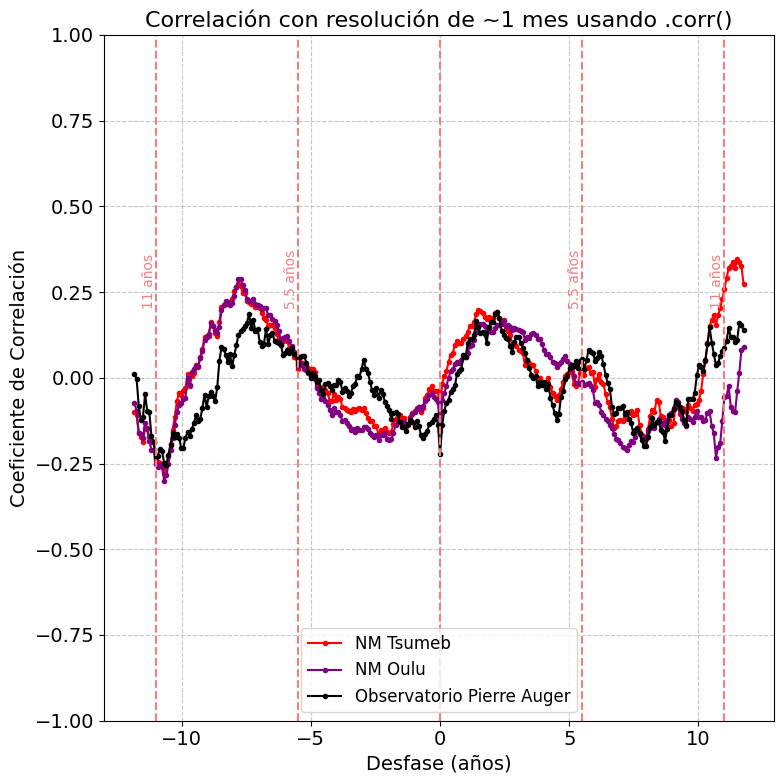

In [44]:
# Define un rango de desfases
lags = np.arange(-30*12*12, 30*12*12, 30)  # Desfases de -12 años a 12 años (en días)

# Define una función para calcular correlaciones con desfases
def calculate_correlations(df, column1, column2, lags):
    correlations = []
    for lag in lags:
        shifted = df[column1].shift(lag)
        correlation = df[column2].corr(shifted)
        correlations.append(correlation)
    return correlations

# Calcula las correlaciones
correlations_CRI = calculate_correlations(df, 'solarw', 'CRI', lags)
correlations_tsumeb = calculate_correlations(df, 'solarw', 'tsumeb', lags)
correlations_oulu = calculate_correlations(df, 'solarw', 'oulu', lags)

# Convierte los desfases a años para la gráfica
lags_years = lags / 365.25

# Crea una gráfica de los coeficientes de correlación
plt.figure(figsize=(8, 8))  # Ajusté el tamaño del gráfico para una mejor visualización
plt.plot(lags_years, correlations_tsumeb, marker='.', linestyle='-', color='red', label='NM Tsumeb')
plt.plot(lags_years, correlations_oulu, marker='.', linestyle='-', color='purple', label='NM Oulu')
plt.plot(lags_years, correlations_CRI, marker='.', linestyle='-', color='black', label='Observatorio Pierre Auger')
plt.xlabel('Desfase (años)', fontsize=14)
plt.ylabel('Coeficiente de Correlación', fontsize=14)
plt.title('Correlación con resolución de ~1 mes usando .corr()', fontsize=16)
plt.ylim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje x
plt.yticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje y

# Añadir líneas verticales en 5.5 y 11 años
plt.axvline(x=5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=0, color='lightcoral', linestyle='--', label='')

# Añadir etiquetas para los años en las líneas verticales
plt.text(5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')


plt.legend(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# PARA LOS DATOS ENTEROS DE OULU Y TSUMEB

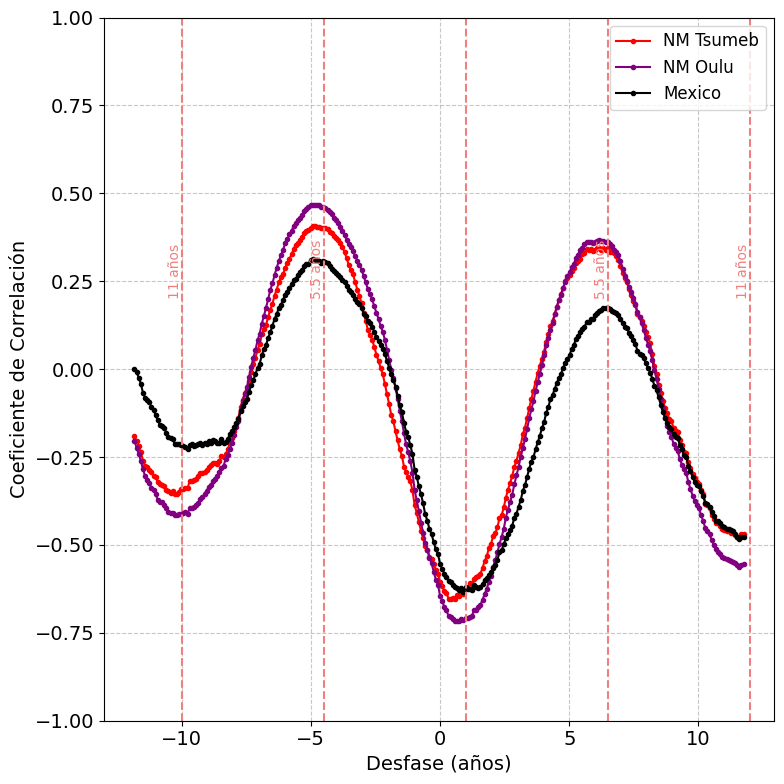

In [66]:
# Define un rango de desfases
lags = np.arange(-30*12*12, 30*12*12, 30)  # Desfases de -12 años a 12 años (en días)

# Define una función para calcular correlaciones con desfases
def calculate_correlations(df, column1, column2, lags):
    correlations = []
    for lag in lags:
        shifted = df[column1].shift(lag)
        correlation = df[column2].corr(shifted)
        correlations.append(correlation)
    return correlations

# Calcula las correlaciones
correlations_CRI = calculate_correlations(merged, 'sunspots', 'mexico', lags)
correlations_tsumeb = calculate_correlations(merged, 'sunspots', 'tsumeb', lags)
correlations_oulu = calculate_correlations(merged, 'sunspots', 'oulu', lags)

# Convierte los desfases a años para la gráfica
lags_years = lags / 365.25

# Crea una gráfica de los coeficientes de correlación
plt.figure(figsize=(8, 8))  # Ajusté el tamaño del gráfico para una mejor visualización
plt.plot(lags_years, correlations_tsumeb, marker='.', linestyle='-', color='red', label='NM Tsumeb')
plt.plot(lags_years, correlations_oulu, marker='.', linestyle='-', color='purple', label='NM Oulu')
plt.plot(lags_years, correlations_CRI, marker='.', linestyle='-', color='black', label='Mexico')
plt.xlabel('Desfase (años)', fontsize=14)
plt.ylabel('Coeficiente de Correlación', fontsize=14)
plt.title('', fontsize=16)
plt.ylim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje x
plt.yticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje y

# Añadir líneas verticales en 5.5 y 11 años
plt.axvline(x=6.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=12, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-4.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-10, color='lightcoral', linestyle='--', label='')
plt.axvline(x=1, color='lightcoral', linestyle='--', label='')

# Añadir etiquetas para los años en las líneas verticales
plt.text(6.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(12, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-4.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-10, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.savefig('corr_NMs_ALLYEARS.png')

plt.legend(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

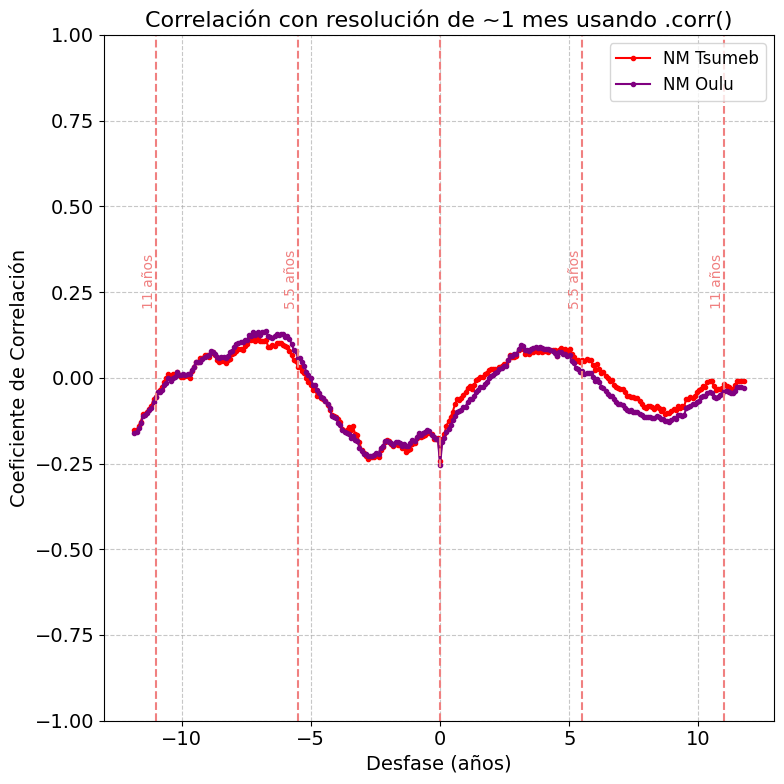

In [48]:
# Define un rango de desfases
lags = np.arange(-30*12*12, 30*12*12, 30)  # Desfases de -12 años a 12 años (en días)

# Define una función para calcular correlaciones con desfases
def calculate_correlations(df, column1, column2, lags):
    correlations = []
    for lag in lags:
        shifted = df[column1].shift(lag)
        correlation = df[column2].corr(shifted)
        correlations.append(correlation)
    return correlations

# Calcula las correlaciones
#correlations_CRI = calculate_correlations(df, 'sunspots', 'CRI', lags)
correlations_tsumeb = calculate_correlations(merged, 'solarw', 'tsumeb', lags)
correlations_oulu = calculate_correlations(merged, 'solarw', 'oulu', lags)

# Convierte los desfases a años para la gráfica
lags_years = lags / 365.25

# Crea una gráfica de los coeficientes de correlación
plt.figure(figsize=(8, 8))  # Ajusté el tamaño del gráfico para una mejor visualización
plt.plot(lags_years, correlations_tsumeb, marker='.', linestyle='-', color='red', label='NM Tsumeb')
plt.plot(lags_years, correlations_oulu, marker='.', linestyle='-', color='purple', label='NM Oulu')
#plt.plot(lags_years, correlations_CRI, marker='.', linestyle='-', color='black', label='Observatorio Pierre Auger')
plt.xlabel('Desfase (años)', fontsize=14)
plt.ylabel('Coeficiente de Correlación', fontsize=14)
plt.title('Correlación con resolución de ~1 mes usando .corr()', fontsize=16)
plt.ylim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje x
plt.yticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje y

# Añadir líneas verticales en 5.5 y 11 años
plt.axvline(x=5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=0, color='lightcoral', linestyle='--', label='')

# Añadir etiquetas para los años en las líneas verticales
plt.text(5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')


plt.legend(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### Solar Wind

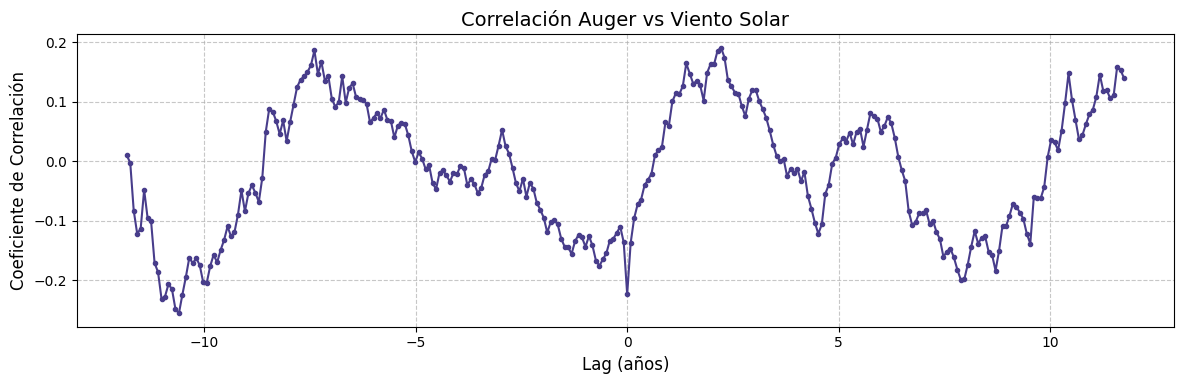

In [36]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = df['solarw'].shift(lag)
    correlation = df['CRI'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(12, 4))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)')
plt.ylabel('Coeficiente de Correlación')
plt.title('Correlación Auger vs Viento Solar')
plt.grid(True, linestyle='--', alpha=0.7)  # Añade una grilla con estilo punteado y transparencia
plt.tight_layout()  # Ajusta el espacio para que todos los elementos se muestren correctamente
plt.show()

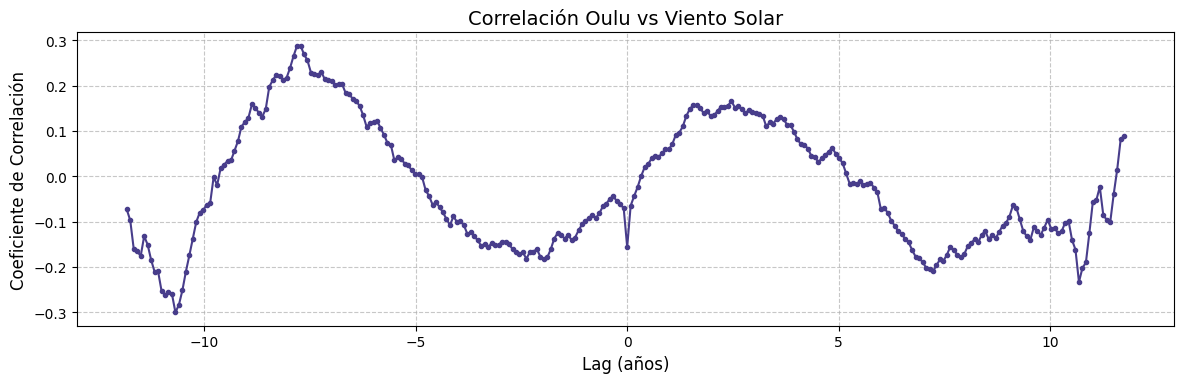

In [37]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = df['solarw'].shift(lag)
    correlation = df['oulu'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(12, 4))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)')
plt.ylabel('Coeficiente de Correlación')
plt.title('Correlación Oulu vs Viento Solar')
plt.grid(True, linestyle='--', alpha=0.7)  # Añade una grilla con estilo punteado y transparencia
plt.tight_layout()  # Ajusta el espacio para que todos los elementos se muestren correctamente
plt.show()

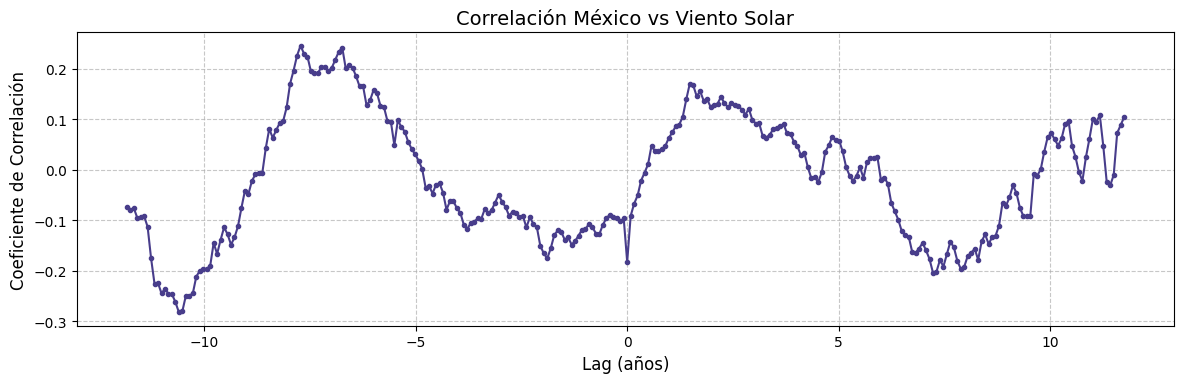

In [38]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = df['solarw'].shift(lag)
    correlation = df['mexico'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(12, 4))
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)')
plt.ylabel('Coeficiente de Correlación')
plt.title('Correlación México vs Viento Solar')
plt.grid(True, linestyle='--', alpha=0.7)  # Añade una grilla con estilo punteado y transparencia
plt.tight_layout()  # Ajusta el espacio para que todos los elementos se muestren correctamente
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


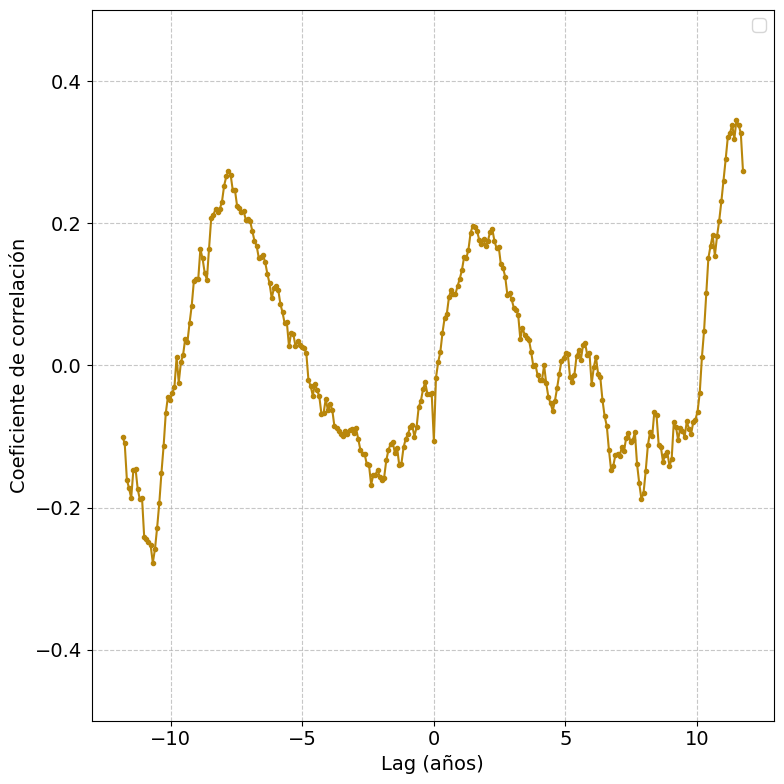

In [108]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = df['solarw'].shift(lag)
    correlation = df['tsumeb'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(8, 8))  # Ajusté el tamaño del gráfico para una mejor visualización
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkgoldenrod')
plt.xlabel('Lag (años)')
plt.ylabel('Coeficiente de Correlación')
plt.ylim(-0.5, 0.5)
plt.title('')

# Añadir líneas verticales en 5.5 y 11 años
#plt.axvline(x=6, color='indianred', linestyle='--', label='')
#plt.axvline(x=11.5, color='indianred', linestyle='--', label='')
#plt.axvline(x=-4.5, color='indianred', linestyle='--', label='')
#plt.axvline(x=-10, color='indianred', linestyle='--', label='')
#plt.axvline(x=1, color='indianred', linestyle='--', label='')

# Añadir etiquetas para los años en las líneas verticales
#plt.text(6, 0.65, '6 años', rotation=90, color='indianred', fontsize=14, ha='right', va='bottom')
#plt.text(11.5, 0.65, '11.5 años', rotation=90, color='indianred', fontsize=14, ha='right', va='bottom')
#plt.text(-4.5, 0.65, '4.5 años', rotation=90, color='indianred', fontsize=14, ha='right', va='bottom')
#plt.text(-10, 0.65, '10 años', rotation=90, color='indianred', fontsize=14, ha='right', va='bottom')
#plt.text(1, 0.65, '1 año', rotation=90, color='indianred', fontsize=14, ha='right', va='bottom')

plt.xlabel('Lag (años)', fontsize=14)  # Ajustar el tamaño de la fuente de la etiqueta del eje x
plt.ylabel('Coeficiente de correlación', fontsize=14) 
plt.xticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje x
plt.yticks(fontsize=14)  # Ajustar el tamaño de la fuente de los tics del eje y
plt.legend(fontsize=14)


plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()  # Añadir leyenda
plt.savefig('corr_tsumeb_sw.pdf')

plt.show()


# TEST DE CÓDIGOS
### Creo datos sintéticos y los aplico a los algoritmos

In [49]:
import numpy as np
import pandas as pd

# Parámetros
amplitude1 = 1.0
amplitude2 = 1.0
frequency = 0.1  # Frecuencia en ciclos por unidad de tiempo
phase_shift = np.pi  # Desfase de 45 grados para generar anticorrelación
num_points = 100

# Generar el tiempo
time = np.arange(0, num_points)

# Generar las dos series sinusoidales
series1 = amplitude1 * np.sin(2 * np.pi * frequency * time)
series2 = amplitude2 * np.sin(2 * np.pi * frequency * time + phase_shift)

# Crear un DataFrame
data = {'Time': time, 'Series1': series1, 'Series2': series2}
test = pd.DataFrame(data)

# Añadir ruido aleatorio para hacerlo más realista (opcional)
#noise = np.random.normal(0, 0.1, num_points)
#test['Series1'] += noise
#test['Series2'] += noise

# Visualizar las primeras filas del DataFrame
print(test.head())

# Ahora puedes usar el código de correlación cruzada que mencionaste para analizar estas series.


   Time   Series1       Series2
0     0  0.000000  1.224647e-16
1     1  0.587785 -5.877853e-01
2     2  0.951057 -9.510565e-01
3     3  0.951057 -9.510565e-01
4     4  0.587785 -5.877853e-01


(0.0, 10.0)

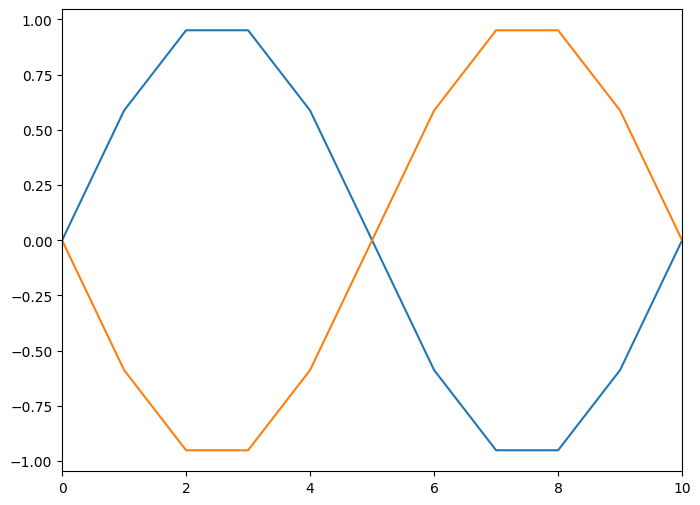

In [50]:
plt.plot(test['Time'],test['Series1'])
plt.plot(test['Time'],test['Series2'])
plt.xlim(0, 10)

## 1) Correlación a mano

In [51]:
# Establece el rango máximo de desplazamiento que deseas explorar
max_lag = 5  # Puedes ajustar esto según tus necesidades

# Inicializa una lista para almacenar los coeficientes de correlación cruzada
cross_correlations_t = []


# Calcula las medias de ambas series
mean_CRI_t = test['Series1'].mean()
mean_sunspots_t = test['Series2'].mean()

# Calcula las desviaciones estándar de ambas series
std_CRI_t = test['Series1'].std()
std_sunspots_t = test['Series2'].std()

# 6. Aplicar la fórmula de correlación cruzada para cada desplazamiento (\Delta)
for lag in range(-max_lag, max_lag + 1):
    sum_product_t = 0
    valid_data_count_t = 0

    for i in range(len(test) - abs(lag)):
        diff_CRI_t = test['Series1'].iloc[i] - mean_CRI_t
        diff_sunspots_t = test['Series2'].iloc[i + lag] - mean_sunspots_t

        if not (np.isnan(diff_CRI_t) or np.isnan(diff_sunspots_t)):
            sum_product_t += diff_CRI_t * diff_sunspots_t
            valid_data_count_t += 1

    # Calcular el coeficiente de correlación cruzada para el desplazamiento actual
    if valid_data_count_t > 0:
        cross_corr_t = (1 / (valid_data_count_t - 1)) * (sum_product_t / (std_CRI_t * std_sunspots_t))
        cross_correlations_t.append(cross_corr_t)
    else:
        cross_correlations_t.append(np.nan)

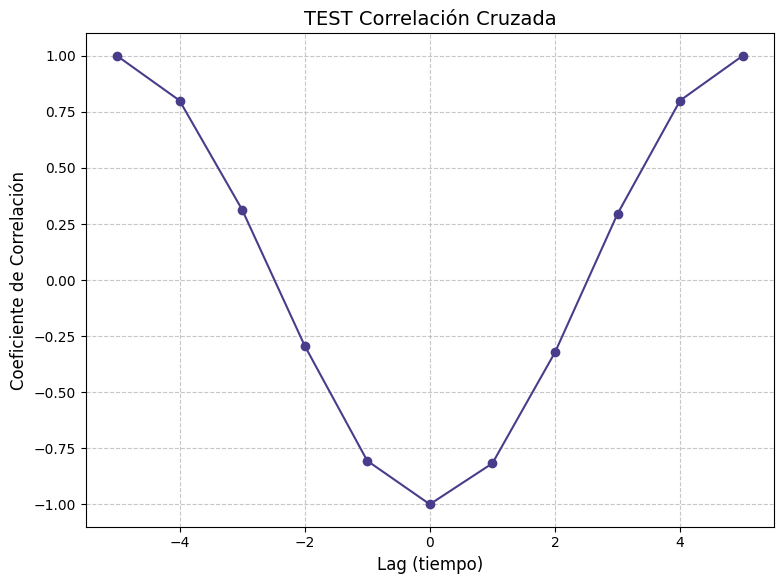

In [67]:
lag_range_t = list(range(-max_lag, max_lag + 1))
plt.plot(lag_range_t, cross_correlations_t, marker='o', linestyle='-', color='darkslateblue')  # Personaliza el color a tu elección
plt.xlabel('Lag (tiempo)')
plt.ylabel('Coeficiente de Correlación')
plt.title('TEST Correlación Cruzada')
plt.grid(True, linestyle='--', alpha=0.7)  # Añade una grilla con estilo punteado y transparencia
plt.tight_layout()  # Ajusta el espacio para que todos los elementos se muestren correctamente
plt.show()


# 2) Correlación hecha con Scipy

In [59]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Función para generar fechas desde una fecha inicial hasta una fecha final con un intervalo de días
def generate_dates(start_date, end_date, delta):
    current_date = start_date
    while current_date <= end_date:
        yield current_date
        current_date += delta

# Definir las fechas de inicio y fin
start_date = datetime(2006, 1, 1)
end_date = datetime(2021, 11, 30)

# Generar fechas con un intervalo diario
dates = list(generate_dates(start_date, end_date, timedelta(days=1)))

# Crear el DataFrame para la señal sinusoidal con periodicidad de 11 años
df_sinusoidal = pd.DataFrame({
    'date': dates,
    'CRI': np.sin(2 * np.pi * np.arange(len(dates)) / (11 * 365.25))  # Señal sinusoidal con periodicidad de 11 años
})

# Crear el DataFrame para la señal sinusoidal completamente anticorrelacionada
df_anticorrelated = pd.DataFrame({
    'date': dates,
    'CRI': -np.sin(2 * np.pi * np.arange(len(dates)) / (11 * 365.25))  # Señal sinusoidal anticorrelacionada
})

# Mostrar las primeras filas de ambos DataFrames
print("DataFrame con señal sinusoidal:")
print(df_sinusoidal.head())

print("\nDataFrame con señal sinusoidal anticorrelacionada:")
print(df_anticorrelated.head())


DataFrame con señal sinusoidal:
        date       CRI
0 2006-01-01  0.000000
1 2006-01-02  0.001564
2 2006-01-03  0.003128
3 2006-01-04  0.004692
4 2006-01-05  0.006255

DataFrame con señal sinusoidal anticorrelacionada:
        date       CRI
0 2006-01-01 -0.000000
1 2006-01-02 -0.001564
2 2006-01-03 -0.003128
3 2006-01-04 -0.004692
4 2006-01-05 -0.006255


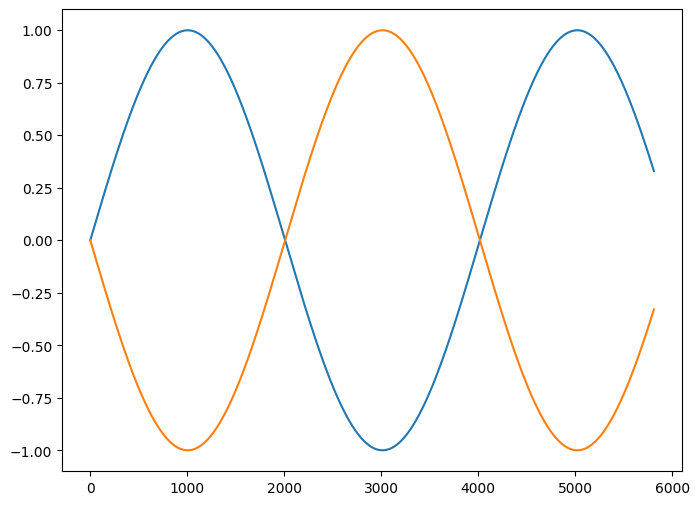

In [62]:
plt.plot(df_sinusoidal['CRI'])
plt.plot(df_anticorrelated['CRI'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


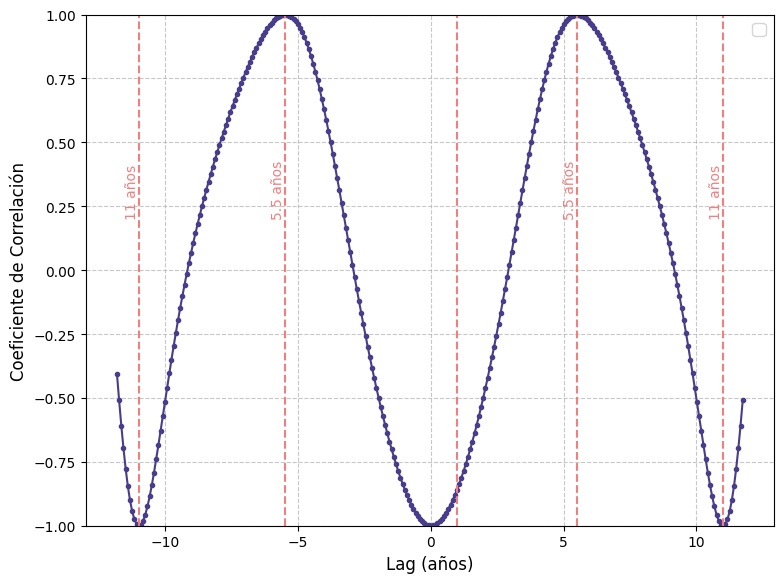

In [60]:
lags = np.arange(-30*12*12, 30*12*12, 30)  # Lags de -12 años a 12 años (en días)
correlations = []

for lag in lags:
    # Desplazar una de las columnas para calcular la correlación con lag
    shifted = df_sinusoidal['CRI'].shift(lag)
    correlation = df_anticorrelated['CRI'].corr(shifted)
    correlations.append(correlation)

# Convertir lags a años para la gráfica
lags_years = lags / 365.25

# Crear un gráfico de los coeficientes de correlación
plt.figure(figsize=(8, 6))  # Ajusté el tamaño del gráfico para una mejor visualización
plt.plot(lags_years, correlations, marker='.', linestyle='-', color='darkslateblue')
plt.xlabel('Lag (años)')
plt.ylabel('Coeficiente de Correlación')
plt.ylim(-1, 1)
plt.title('')

# Añadir líneas verticales en 5.5 y 11 años
plt.axvline(x=5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-5.5, color='lightcoral', linestyle='--', label='')
plt.axvline(x=-11, color='lightcoral', linestyle='--', label='')
plt.axvline(x=1, color='lightcoral', linestyle='--', label='')


# Añadir etiquetas para los años en las líneas verticales
plt.text(5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-5.5, 0.2, '5.5 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')
plt.text(-11, 0.2, '11 años', rotation=90, color='lightcoral', fontsize=10, ha='right', va='bottom')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()  # Añadir leyenda
#plt.savefig('corr_auger_sn.pdf')

plt.show()